# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

   # used to aquire dataset
import acquire_telco as aq
   # used to prepare and clean the dataset
import prepare_telco as pp

   # make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Aquistion

In [2]:
# The function get_telco_data() I created in the file acquire.py pulls the dataset straight from SQL
# UNLESS the data has already been downloaded as a .csv,
# in which case the function will pull the data straight from that file instead.

df = aq.get_telco_data()
df.info()

Reading from csv file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-nul

# Data Preperation

In [3]:
# The function prep_telco() that I created in the file prepare.py takes in the Telco dataframe and cleans it
# It does this by dropping uneeded columns ['payment_type_id', 'internet_service_type_id', 'contract_type_id']
# I also made sure the function cleared any nulls from the dataset
# Lastly, I make it easier to manipulate the data by creating dummy column for each categorical column.

In [4]:
telco_df = df
df = pp.prep_telco(df)
df.head(2)

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0002-ORFBO,0,9,65.6,593.3,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
1,0003-MKNFE,0,9,59.9,542.4,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [5]:
# check for null values
df.isna().sum()

customer_id                              0
senior_citizen                           0
tenure                                   0
monthly_charges                          0
total_charges                            0
gender_Male                              0
partner_Yes                              0
dependents_Yes                           0
phone_service_Yes                        0
multiple_lines_No phone service          0
multiple_lines_Yes                       0
online_security_No internet service      0
online_security_Yes                      0
online_backup_No internet service        0
online_backup_Yes                        0
device_protection_No internet service    0
device_protection_Yes                    0
tech_support_No internet service         0
tech_support_Yes                         0
streaming_tv_No internet service         0
streaming_tv_Yes                         0
streaming_movies_No internet service     0
streaming_movies_Yes                     0
paperless_b

In [6]:
# rename columns for readability

df.rename(columns={'gender_Male': 'is_male',
                   'partner_Yes': 'married',
                   'dependents_Yes': 'children',
                   'phone_service_Yes': 'phone_service',
                   'multiple_lines_No phone service': 'no_phone_multiple_lines',
                   'multiple_lines_Yes': 'multiple_lines',
                   'online_security_No internet service': 'no_internet_online_security',
                   'online_security_Yes': 'online_security',
                   'online_backup_No internet service': 'no_internet_online_backup',
                   'online_backup_Yes': 'online_backup',
                   'device_protection_No internet service': 'no_internet_device_protection',
                   'device_protection_Yes': 'device_protection',
                   'tech_support_No internet service': 'no_internet_tech_support',
                   'tech_support_Yes': 'tech_support',
                   'streaming_tv_No internet service': 'no_internet_streaming_tv',
                   'streaming_tv_Yes': 'streaming_tv',
                   'streaming_movies_No internet service': 'no_internet_streaming_movies',
                   'streaming_movies_Yes': 'streaming_movies',
                   'paperless_billing_Yes': 'paperless_billing',
                   'churn_Yes': 'churn',
                   'contract_type_One year': 'one_year_contract',
                   'contract_type_Two year': 'two_year_contract',
                   'internet_service_type_Fiber optic': 'fiber_optic',
                   'internet_service_type_None': 'no_internet',
                   'payment_type_Credit card (automatic)': 'card_auto_pay',
                   'payment_type_Electronic check': 'electronic_check',
                   'payment_type_Mailed check': 'mailed_check'}, inplace=True)

# also drop customer id for training purposes
df = df.drop(columns=['customer_id'])

In [7]:
# check the sum of each column to see if there is any redundancy
# doing so shows that several columns made for the dummy list can be represented by just 1 column
# the 'no_internet' column
df = df.drop(columns=['no_internet_streaming_movies',
                      'no_internet_streaming_tv',
                      'no_internet_tech_support',
                      'no_internet_device_protection', 
                      'no_internet_online_backup',
                      'no_internet_online_security',
                      'no_phone_multiple_lines'])

df.head(3)
# now we can move forward to exploring the data with visuals and statistics

,senior_citizen,tenure,monthly_charges,total_charges,is_male,married,children,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,one_year_contract,two_year_contract,fiber_optic,no_internet,card_auto_pay,electronic_check,mailed_check
0,0,9,65.6,593.30,0,1,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,1
1,0,9,59.9,542.40,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,4,73.9,280.85,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0


# Exploratory Data Analysis and Statistical Testing

In [8]:
df.churn.value_counts()

0    5174
1    1869
Name: churn, dtype: int64

In [9]:
# details on 
telco_df.contract_type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64

In [10]:
# details on tenure
telco_df.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

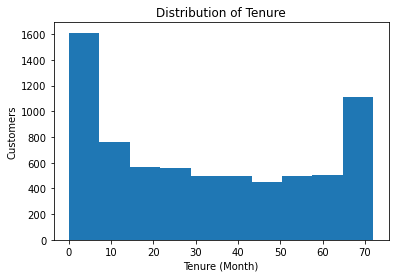

In [11]:
# distribution of tenure
plt.title('Distribution of Tenure')
plt.hist(x='tenure', data=df)
plt.xlabel('Tenure (Month)')
plt.ylabel('Customers')
plt.show()

In [12]:
# Two peaks, indicating two possible populations to explore
# Not a normal distribution


df.describe()
# this will give a few metrics to measure with when doing statistical exploration

,senior_citizen,tenure,monthly_charges,total_charges,is_male,married,children,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,one_year_contract,two_year_contract,fiber_optic,no_internet,card_auto_pay,electronic_check,mailed_check
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.504756,0.483033,0.299588,0.903166,0.421837,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.592219,0.265370,0.209144,0.240664,0.439585,0.216669,0.216101,0.335794,0.228880
std,0.368612,24.559481,30.090047,2266.794470,0.500013,0.499748,0.458110,0.295752,0.493888,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.491457,0.441561,0.406726,0.427517,0.496372,0.412004,0.411613,0.472301,0.420141
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,398.550000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1394.550000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Explore the distribution of Total Charges
df.total_charges.describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

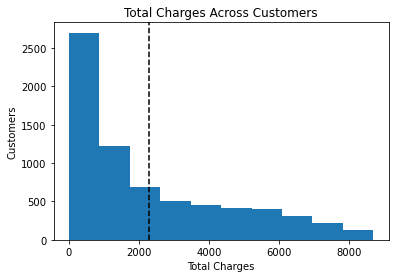

In [14]:
plt.title('Total Charges Across Customers')
plt.hist(x='total_charges', data=df)
plt.xlabel('Total Charges')
plt.ylabel('Customers')
plt.axvline(x=df['total_charges'].mean(), color='k', linestyle='dashed')
plt.show()

# Question 1 
- How long are customers that churn staying with us?
- What's their lifetime charges (total charges)?
- How do their total charges differ from those that did not churn

In [20]:
# Let's take a closer look at accounts that churned to look for possible variables
churned_df = df[df.churn == 1]

# Verify changes and examine the distribution of total charges over tenure
churned_df.total_charges.describe()

count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: total_charges, dtype: float64

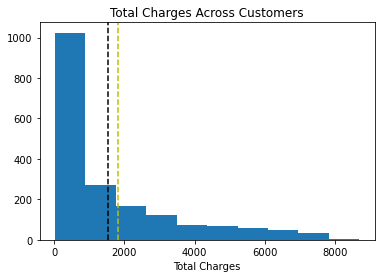

In [36]:
# Vizualize the distribution
plt.title('Total Charges Across Customers')
plt.hist(x='total_charges', data=churned_df)
plt.xlabel('Total Charges')
plt.axvline(x=churned_df['total_charges'].mean(), color='k', linestyle='dashed')
plt.axvline(x=churned_df['total_charges'].quantile(0.7), color='y', linestyle='dashed')
plt.show()

In [38]:
# There is a clear skew to the data
# Almost 70% of customers churned before reaching a lifetime value(LTV) of 
churned_df.total_charges.quantile(0.7)

1800.9199999999983

In [17]:
df.total_charges.quantile(0.8)

4471.440000000001

In [18]:
# almost done prepping the data,
# now to split the data into our train, validate, and test samples

train, test = train_test_split(df, 
                               train_size = 0.8,
                               random_state=1313)

train, validate = train_test_split(train,
                                  train_size = 0.7,
                                  random_state=1313)

train.shape, validate.shape, test.shape

((3943, 24), (1691, 24), (1409, 24))

# Modeling to fit the Data

# Model Evaluation

# Finding and Key Takeaways